In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        #{'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['t1'],
    'features_clin' : None,
    'outp'          : 'basal_seg',
    'balance_data'  : False,
    'exclude'       : ['normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_0_0_0_1_normalized_e_n_e_0_0_t1_0_0_basal_seg_data_norm_e_e_0_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(673340, 1)
(673340, 3)
validation
(95538, 1)
(95538, 3)
test
(86036, 1)
(86036, 3)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1)]               0         


 dense (Dense)               (None, 1024)              2048      


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 3)                 387       


Total params: 691459 (2.64 MB)


Trainable params: 691459 (2.64 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/68 [..............................] - ETA: 1:34 - loss: 1.6780 - STD: 0.2218 - MAE: 0.5285

 7/68 [==>...........................] - ETA: 0s - loss: 1.0635 - STD: 0.1709 - MAE: 0.4080  

13/68 [====>.........................] - ETA: 0s - loss: 1.0049 - STD: 0.1979 - MAE: 0.3841

20/68 [=======>......................] - ETA: 0s - loss: 0.9793 - STD: 0.2090 - MAE: 0.3741

27/68 [==========>...................] - ETA: 0s - loss: 0.9609 - STD: 0.2113 - MAE: 0.3705

34/68 [==============>...............] - ETA: 0s - loss: 0.9470 - STD: 0.2063 - MAE: 0.3709

41/68 [=================>............] - ETA: 0s - loss: 0.9382 - STD: 0.2008 - MAE: 0.3719

46/68 [===================>..........] - ETA: 0s - loss: 0.9336 - STD: 0.1992 - MAE: 0.3719

53/68 [======================>.......] - ETA: 0s - loss: 0.9266 - STD: 0.1989 - MAE: 0.3710

60/68 [=========================>....] - ETA: 0s - loss: 0.9213 - STD: 0.1991 - MAE: 0.3701

67/68 [============================>.] - ETA: 0s - loss: 0.9163 - STD: 0.1989 - MAE: 0.3693

68/68 [==============================] - 3s 29ms/step - loss: 0.9154 - STD: 0.1988 - MAE: 0.3691 - val_loss: 0.8357 - val_STD: 0.2024 - val_MAE: 0.3486


Epoch 2/10000


 1/68 [..............................] - ETA: 1s - loss: 0.8482 - STD: 0.1973 - MAE: 0.3563

 8/68 [==>...........................] - ETA: 0s - loss: 0.8527 - STD: 0.2007 - MAE: 0.3549

15/68 [=====>........................] - ETA: 0s - loss: 0.8476 - STD: 0.2075 - MAE: 0.3507

22/68 [========>.....................] - ETA: 0s - loss: 0.8425 - STD: 0.2131 - MAE: 0.3472

29/68 [===========>..................] - ETA: 0s - loss: 0.8387 - STD: 0.2171 - MAE: 0.3447

36/68 [==============>...............] - ETA: 0s - loss: 0.8376 - STD: 0.2193 - MAE: 0.3435

43/68 [=================>............] - ETA: 0s - loss: 0.8363 - STD: 0.2210 - MAE: 0.3426

50/68 [=====================>........] - ETA: 0s - loss: 0.8355 - STD: 0.2225 - MAE: 0.3418

57/68 [========================>.....] - ETA: 0s - loss: 0.8349 - STD: 0.2234 - MAE: 0.3412

64/68 [===========================>..] - ETA: 0s - loss: 0.8345 - STD: 0.2242 - MAE: 0.3408

68/68 [==============================] - 1s 9ms/step - loss: 0.8343 - STD: 0.2246 - MAE: 0.3406 - val_loss: 0.7965 - val_STD: 0.2438 - val_MAE: 0.3208


Epoch 3/10000


 1/68 [..............................] - ETA: 1s - loss: 0.8248 - STD: 0.2337 - MAE: 0.3351

 8/68 [==>...........................] - ETA: 0s - loss: 0.8323 - STD: 0.2320 - MAE: 0.3370

15/68 [=====>........................] - ETA: 0s - loss: 0.8290 - STD: 0.2329 - MAE: 0.3359

22/68 [========>.....................] - ETA: 0s - loss: 0.8285 - STD: 0.2326 - MAE: 0.3359

29/68 [===========>..................] - ETA: 0s - loss: 0.8282 - STD: 0.2330 - MAE: 0.3357

36/68 [==============>...............] - ETA: 0s - loss: 0.8285 - STD: 0.2331 - MAE: 0.3358

43/68 [=================>............] - ETA: 0s - loss: 0.8282 - STD: 0.2326 - MAE: 0.3360

50/68 [=====================>........] - ETA: 0s - loss: 0.8282 - STD: 0.2327 - MAE: 0.3359

57/68 [========================>.....] - ETA: 0s - loss: 0.8285 - STD: 0.2329 - MAE: 0.3359

64/68 [===========================>..] - ETA: 0s - loss: 0.8289 - STD: 0.2326 - MAE: 0.3361

68/68 [==============================] - 1s 9ms/step - loss: 0.8286 - STD: 0.2325 - MAE: 0.3361 - val_loss: 0.7937 - val_STD: 0.2392 - val_MAE: 0.3227


Epoch 4/10000


 1/68 [..............................] - ETA: 1s - loss: 0.8346 - STD: 0.2299 - MAE: 0.3387

 8/68 [==>...........................] - ETA: 0s - loss: 0.8259 - STD: 0.2363 - MAE: 0.3340

15/68 [=====>........................] - ETA: 0s - loss: 0.8263 - STD: 0.2347 - MAE: 0.3348

22/68 [========>.....................] - ETA: 0s - loss: 0.8269 - STD: 0.2337 - MAE: 0.3353

29/68 [===========>..................] - ETA: 0s - loss: 0.8274 - STD: 0.2334 - MAE: 0.3355

36/68 [==============>...............] - ETA: 0s - loss: 0.8279 - STD: 0.2334 - MAE: 0.3356

43/68 [=================>............] - ETA: 0s - loss: 0.8276 - STD: 0.2334 - MAE: 0.3355

50/68 [=====================>........] - ETA: 0s - loss: 0.8273 - STD: 0.2334 - MAE: 0.3355

57/68 [========================>.....] - ETA: 0s - loss: 0.8274 - STD: 0.2336 - MAE: 0.3354

63/68 [==========================>...] - ETA: 0s - loss: 0.8273 - STD: 0.2333 - MAE: 0.3355

68/68 [==============================] - 1s 9ms/step - loss: 0.8271 - STD: 0.2336 - MAE: 0.3353 - val_loss: 0.7947 - val_STD: 0.2476 - val_MAE: 0.3186


Epoch 5/10000


 1/68 [..............................] - ETA: 1s - loss: 0.8373 - STD: 0.2371 - MAE: 0.3363

 8/68 [==>...........................] - ETA: 0s - loss: 0.8296 - STD: 0.2309 - MAE: 0.3370

15/68 [=====>........................] - ETA: 0s - loss: 0.8283 - STD: 0.2334 - MAE: 0.3356

22/68 [========>.....................] - ETA: 0s - loss: 0.8289 - STD: 0.2324 - MAE: 0.3362

29/68 [===========>..................] - ETA: 0s - loss: 0.8298 - STD: 0.2326 - MAE: 0.3363

36/68 [==============>...............] - ETA: 0s - loss: 0.8284 - STD: 0.2325 - MAE: 0.3361

43/68 [=================>............] - ETA: 0s - loss: 0.8285 - STD: 0.2329 - MAE: 0.3359

50/68 [=====================>........] - ETA: 0s - loss: 0.8283 - STD: 0.2328 - MAE: 0.3360

57/68 [========================>.....] - ETA: 0s - loss: 0.8274 - STD: 0.2328 - MAE: 0.3358

64/68 [===========================>..] - ETA: 0s - loss: 0.8270 - STD: 0.2335 - MAE: 0.3354

68/68 [==============================] - 1s 9ms/step - loss: 0.8271 - STD: 0.2334 - MAE: 0.3355 - val_loss: 0.7972 - val_STD: 0.2430 - val_MAE: 0.3218


Epoch 6/10000


 1/68 [..............................] - ETA: 1s - loss: 0.8250 - STD: 0.2321 - MAE: 0.3358

 8/68 [==>...........................] - ETA: 0s - loss: 0.8246 - STD: 0.2327 - MAE: 0.3353

15/68 [=====>........................] - ETA: 0s - loss: 0.8267 - STD: 0.2326 - MAE: 0.3358

22/68 [========>.....................] - ETA: 0s - loss: 0.8282 - STD: 0.2328 - MAE: 0.3360

29/68 [===========>..................] - ETA: 0s - loss: 0.8276 - STD: 0.2321 - MAE: 0.3363

36/68 [==============>...............] - ETA: 0s - loss: 0.8272 - STD: 0.2331 - MAE: 0.3357

43/68 [=================>............] - ETA: 0s - loss: 0.8276 - STD: 0.2329 - MAE: 0.3358

50/68 [=====================>........] - ETA: 0s - loss: 0.8273 - STD: 0.2329 - MAE: 0.3358

57/68 [========================>.....] - ETA: 0s - loss: 0.8271 - STD: 0.2334 - MAE: 0.3355

64/68 [===========================>..] - ETA: 0s - loss: 0.8268 - STD: 0.2333 - MAE: 0.3354

68/68 [==============================] - 1s 9ms/step - loss: 0.8266 - STD: 0.2333 - MAE: 0.3354 - val_loss: 0.8048 - val_STD: 0.2528 - val_MAE: 0.3187


Epoch 7/10000


 1/68 [..............................] - ETA: 1s - loss: 0.8313 - STD: 0.2408 - MAE: 0.3334

 8/68 [==>...........................] - ETA: 0s - loss: 0.8250 - STD: 0.2346 - MAE: 0.3347

15/68 [=====>........................] - ETA: 0s - loss: 0.8282 - STD: 0.2351 - MAE: 0.3349

22/68 [========>.....................] - ETA: 0s - loss: 0.8277 - STD: 0.2331 - MAE: 0.3357

29/68 [===========>..................] - ETA: 0s - loss: 0.8273 - STD: 0.2342 - MAE: 0.3351

36/68 [==============>...............] - ETA: 0s - loss: 0.8270 - STD: 0.2340 - MAE: 0.3351

43/68 [=================>............] - ETA: 0s - loss: 0.8272 - STD: 0.2337 - MAE: 0.3353

50/68 [=====================>........] - ETA: 0s - loss: 0.8273 - STD: 0.2338 - MAE: 0.3353

57/68 [========================>.....] - ETA: 0s - loss: 0.8273 - STD: 0.2335 - MAE: 0.3355

64/68 [===========================>..] - ETA: 0s - loss: 0.8270 - STD: 0.2338 - MAE: 0.3353

68/68 [==============================] - 1s 9ms/step - loss: 0.8270 - STD: 0.2337 - MAE: 0.3353 - val_loss: 0.7997 - val_STD: 0.2466 - val_MAE: 0.3207


Epoch 8/10000


 1/68 [..............................] - ETA: 1s - loss: 0.8290 - STD: 0.2332 - MAE: 0.3359

 8/68 [==>...........................] - ETA: 0s - loss: 0.8266 - STD: 0.2336 - MAE: 0.3352

14/68 [=====>........................] - ETA: 0s - loss: 0.8257 - STD: 0.2340 - MAE: 0.3349

21/68 [========>.....................] - ETA: 0s - loss: 0.8249 - STD: 0.2341 - MAE: 0.3348

28/68 [===========>..................] - ETA: 0s - loss: 0.8250 - STD: 0.2339 - MAE: 0.3349

35/68 [==============>...............] - ETA: 0s - loss: 0.8251 - STD: 0.2342 - MAE: 0.3347

41/68 [=================>............] - ETA: 0s - loss: 0.8258 - STD: 0.2340 - MAE: 0.3350

48/68 [====================>.........] - ETA: 0s - loss: 0.8259 - STD: 0.2338 - MAE: 0.3350

55/68 [=======================>......] - ETA: 0s - loss: 0.8256 - STD: 0.2339 - MAE: 0.3349

62/68 [==========================>...] - ETA: 0s - loss: 0.8257 - STD: 0.2341 - MAE: 0.3349

68/68 [==============================] - ETA: 0s - loss: 0.8263 - STD: 0.2337 - MAE: 0.3352

68/68 [==============================] - 1s 9ms/step - loss: 0.8263 - STD: 0.2337 - MAE: 0.3352 - val_loss: 0.7957 - val_STD: 0.2376 - val_MAE: 0.3242


Epoch 9/10000


 1/68 [..............................] - ETA: 1s - loss: 0.8246 - STD: 0.2258 - MAE: 0.3385

 8/68 [==>...........................] - ETA: 0s - loss: 0.8259 - STD: 0.2342 - MAE: 0.3349

15/68 [=====>........................] - ETA: 0s - loss: 0.8262 - STD: 0.2337 - MAE: 0.3353

22/68 [========>.....................] - ETA: 0s - loss: 0.8259 - STD: 0.2341 - MAE: 0.3351

29/68 [===========>..................] - ETA: 0s - loss: 0.8268 - STD: 0.2339 - MAE: 0.3352

36/68 [==============>...............] - ETA: 0s - loss: 0.8263 - STD: 0.2335 - MAE: 0.3354

43/68 [=================>............] - ETA: 0s - loss: 0.8263 - STD: 0.2340 - MAE: 0.3351

50/68 [=====================>........] - ETA: 0s - loss: 0.8265 - STD: 0.2336 - MAE: 0.3353

57/68 [========================>.....] - ETA: 0s - loss: 0.8265 - STD: 0.2338 - MAE: 0.3352

64/68 [===========================>..] - ETA: 0s - loss: 0.8265 - STD: 0.2339 - MAE: 0.3352

68/68 [==============================] - 1s 9ms/step - loss: 0.8266 - STD: 0.2338 - MAE: 0.3352 - val_loss: 0.7995 - val_STD: 0.2448 - val_MAE: 0.3215


Epoch 10/10000


 1/68 [..............................] - ETA: 1s - loss: 0.8186 - STD: 0.2330 - MAE: 0.3335

 8/68 [==>...........................] - ETA: 0s - loss: 0.8281 - STD: 0.2324 - MAE: 0.3362

15/68 [=====>........................] - ETA: 0s - loss: 0.8277 - STD: 0.2329 - MAE: 0.3360

22/68 [========>.....................] - ETA: 0s - loss: 0.8279 - STD: 0.2330 - MAE: 0.3360

29/68 [===========>..................] - ETA: 0s - loss: 0.8276 - STD: 0.2331 - MAE: 0.3359

36/68 [==============>...............] - ETA: 0s - loss: 0.8277 - STD: 0.2331 - MAE: 0.3358

43/68 [=================>............] - ETA: 0s - loss: 0.8277 - STD: 0.2330 - MAE: 0.3359

50/68 [=====================>........] - ETA: 0s - loss: 0.8276 - STD: 0.2332 - MAE: 0.3358

57/68 [========================>.....] - ETA: 0s - loss: 0.8271 - STD: 0.2335 - MAE: 0.3355

64/68 [===========================>..] - ETA: 0s - loss: 0.8271 - STD: 0.2336 - MAE: 0.3354

68/68 [==============================] - 1s 9ms/step - loss: 0.8267 - STD: 0.2336 - MAE: 0.3354 - val_loss: 0.7905 - val_STD: 0.2400 - val_MAE: 0.3218


Epoch 11/10000


 1/68 [..............................] - ETA: 1s - loss: 0.8266 - STD: 0.2306 - MAE: 0.3364

 8/68 [==>...........................] - ETA: 0s - loss: 0.8263 - STD: 0.2369 - MAE: 0.3339

15/68 [=====>........................] - ETA: 0s - loss: 0.8264 - STD: 0.2340 - MAE: 0.3353

22/68 [========>.....................] - ETA: 0s - loss: 0.8269 - STD: 0.2343 - MAE: 0.3351

29/68 [===========>..................] - ETA: 0s - loss: 0.8276 - STD: 0.2335 - MAE: 0.3357

36/68 [==============>...............] - ETA: 0s - loss: 0.8267 - STD: 0.2339 - MAE: 0.3353

43/68 [=================>............] - ETA: 0s - loss: 0.8261 - STD: 0.2341 - MAE: 0.3351

50/68 [=====================>........] - ETA: 0s - loss: 0.8265 - STD: 0.2340 - MAE: 0.3352

57/68 [========================>.....] - ETA: 0s - loss: 0.8269 - STD: 0.2339 - MAE: 0.3353

64/68 [===========================>..] - ETA: 0s - loss: 0.8270 - STD: 0.2337 - MAE: 0.3354

68/68 [==============================] - 1s 9ms/step - loss: 0.8270 - STD: 0.2338 - MAE: 0.3353 - val_loss: 0.7966 - val_STD: 0.2469 - val_MAE: 0.3198


Epoch 12/10000


 1/68 [..............................] - ETA: 1s - loss: 0.8282 - STD: 0.2356 - MAE: 0.3352

 8/68 [==>...........................] - ETA: 0s - loss: 0.8214 - STD: 0.2350 - MAE: 0.3335

15/68 [=====>........................] - ETA: 0s - loss: 0.8253 - STD: 0.2349 - MAE: 0.3343

21/68 [========>.....................] - ETA: 0s - loss: 0.8259 - STD: 0.2337 - MAE: 0.3350

28/68 [===========>..................] - ETA: 0s - loss: 0.8260 - STD: 0.2347 - MAE: 0.3345

35/68 [==============>...............] - ETA: 0s - loss: 0.8262 - STD: 0.2338 - MAE: 0.3350

42/68 [=================>............] - ETA: 0s - loss: 0.8256 - STD: 0.2341 - MAE: 0.3348

49/68 [====================>.........] - ETA: 0s - loss: 0.8257 - STD: 0.2342 - MAE: 0.3348

56/68 [=======================>......] - ETA: 0s - loss: 0.8257 - STD: 0.2339 - MAE: 0.3350

63/68 [==========================>...] - ETA: 0s - loss: 0.8258 - STD: 0.2341 - MAE: 0.3349

68/68 [==============================] - 1s 9ms/step - loss: 0.8259 - STD: 0.2340 - MAE: 0.3350 - val_loss: 0.7946 - val_STD: 0.2414 - val_MAE: 0.3221


Epoch 13/10000


 1/68 [..............................] - ETA: 1s - loss: 0.8214 - STD: 0.2301 - MAE: 0.3362

 8/68 [==>...........................] - ETA: 0s - loss: 0.8220 - STD: 0.2356 - MAE: 0.3336

15/68 [=====>........................] - ETA: 0s - loss: 0.8250 - STD: 0.2347 - MAE: 0.3345

22/68 [========>.....................] - ETA: 0s - loss: 0.8257 - STD: 0.2337 - MAE: 0.3351

29/68 [===========>..................] - ETA: 0s - loss: 0.8261 - STD: 0.2341 - MAE: 0.3349

36/68 [==============>...............] - ETA: 0s - loss: 0.8258 - STD: 0.2337 - MAE: 0.3351

43/68 [=================>............] - ETA: 0s - loss: 0.8263 - STD: 0.2339 - MAE: 0.3351

51/68 [=====================>........] - ETA: 0s - loss: 0.8261 - STD: 0.2339 - MAE: 0.3351

58/68 [========================>.....] - ETA: 0s - loss: 0.8258 - STD: 0.2339 - MAE: 0.3350

65/68 [===========================>..] - ETA: 0s - loss: 0.8259 - STD: 0.2339 - MAE: 0.3350

68/68 [==============================] - 1s 9ms/step - loss: 0.8259 - STD: 0.2338 - MAE: 0.3351 - val_loss: 0.7953 - val_STD: 0.2440 - val_MAE: 0.3210


Epoch 14/10000


 1/68 [..............................] - ETA: 1s - loss: 0.8246 - STD: 0.2317 - MAE: 0.3357

 8/68 [==>...........................] - ETA: 0s - loss: 0.8264 - STD: 0.2352 - MAE: 0.3346

15/68 [=====>........................] - ETA: 0s - loss: 0.8269 - STD: 0.2346 - MAE: 0.3348

22/68 [========>.....................] - ETA: 0s - loss: 0.8273 - STD: 0.2334 - MAE: 0.3355

29/68 [===========>..................] - ETA: 0s - loss: 0.8270 - STD: 0.2340 - MAE: 0.3352

36/68 [==============>...............] - ETA: 0s - loss: 0.8268 - STD: 0.2340 - MAE: 0.3351

43/68 [=================>............] - ETA: 0s - loss: 0.8264 - STD: 0.2340 - MAE: 0.3351

50/68 [=====================>........] - ETA: 0s - loss: 0.8261 - STD: 0.2342 - MAE: 0.3349

57/68 [========================>.....] - ETA: 0s - loss: 0.8264 - STD: 0.2340 - MAE: 0.3351

64/68 [===========================>..] - ETA: 0s - loss: 0.8263 - STD: 0.2341 - MAE: 0.3350

68/68 [==============================] - 1s 9ms/step - loss: 0.8260 - STD: 0.2341 - MAE: 0.3350 - val_loss: 0.8007 - val_STD: 0.2513 - val_MAE: 0.3186


Epoch 15/10000


 1/68 [..............................] - ETA: 1s - loss: 0.8126 - STD: 0.2384 - MAE: 0.3311

 8/68 [==>...........................] - ETA: 0s - loss: 0.8261 - STD: 0.2338 - MAE: 0.3352

15/68 [=====>........................] - ETA: 0s - loss: 0.8246 - STD: 0.2344 - MAE: 0.3346

22/68 [========>.....................] - ETA: 0s - loss: 0.8256 - STD: 0.2344 - MAE: 0.3348

29/68 [===========>..................] - ETA: 0s - loss: 0.8256 - STD: 0.2341 - MAE: 0.3349

36/68 [==============>...............] - ETA: 0s - loss: 0.8258 - STD: 0.2342 - MAE: 0.3349

43/68 [=================>............] - ETA: 0s - loss: 0.8258 - STD: 0.2341 - MAE: 0.3349

50/68 [=====================>........] - ETA: 0s - loss: 0.8258 - STD: 0.2341 - MAE: 0.3349

56/68 [=======================>......] - ETA: 0s - loss: 0.8259 - STD: 0.2342 - MAE: 0.3349

64/68 [===========================>..] - ETA: 0s - loss: 0.8258 - STD: 0.2342 - MAE: 0.3348

68/68 [==============================] - 1s 9ms/step - loss: 0.8258 - STD: 0.2341 - MAE: 0.3349 - val_loss: 0.8002 - val_STD: 0.2462 - val_MAE: 0.3210


Epoch 16/10000


 1/68 [..............................] - ETA: 1s - loss: 0.8151 - STD: 0.2349 - MAE: 0.3329

 8/68 [==>...........................] - ETA: 0s - loss: 0.8239 - STD: 0.2347 - MAE: 0.3344

15/68 [=====>........................] - ETA: 0s - loss: 0.8234 - STD: 0.2351 - MAE: 0.3340

22/68 [========>.....................] - ETA: 0s - loss: 0.8237 - STD: 0.2351 - MAE: 0.3340

29/68 [===========>..................] - ETA: 0s - loss: 0.8244 - STD: 0.2345 - MAE: 0.3345

36/68 [==============>...............] - ETA: 0s - loss: 0.8239 - STD: 0.2349 - MAE: 0.3342

43/68 [=================>............] - ETA: 0s - loss: 0.8248 - STD: 0.2345 - MAE: 0.3345

50/68 [=====================>........] - ETA: 0s - loss: 0.8253 - STD: 0.2344 - MAE: 0.3346

57/68 [========================>.....] - ETA: 0s - loss: 0.8256 - STD: 0.2343 - MAE: 0.3347

64/68 [===========================>..] - ETA: 0s - loss: 0.8259 - STD: 0.2341 - MAE: 0.3349

68/68 [==============================] - 1s 9ms/step - loss: 0.8258 - STD: 0.2341 - MAE: 0.3349 - val_loss: 0.7980 - val_STD: 0.2460 - val_MAE: 0.3207


Epoch 17/10000


 1/68 [..............................] - ETA: 1s - loss: 0.8234 - STD: 0.2345 - MAE: 0.3336

 7/68 [==>...........................] - ETA: 0s - loss: 0.8204 - STD: 0.2368 - MAE: 0.3327

13/68 [====>.........................] - ETA: 0s - loss: 0.8214 - STD: 0.2360 - MAE: 0.3332

20/68 [=======>......................] - ETA: 0s - loss: 0.8224 - STD: 0.2355 - MAE: 0.3337

27/68 [==========>...................] - ETA: 0s - loss: 0.8238 - STD: 0.2350 - MAE: 0.3341

34/68 [==============>...............] - ETA: 0s - loss: 0.8249 - STD: 0.2343 - MAE: 0.3347

41/68 [=================>............] - ETA: 0s - loss: 0.8253 - STD: 0.2346 - MAE: 0.3346

48/68 [====================>.........] - ETA: 0s - loss: 0.8256 - STD: 0.2343 - MAE: 0.3348

55/68 [=======================>......] - ETA: 0s - loss: 0.8257 - STD: 0.2341 - MAE: 0.3349

62/68 [==========================>...] - ETA: 0s - loss: 0.8261 - STD: 0.2342 - MAE: 0.3350

68/68 [==============================] - 1s 9ms/step - loss: 0.8260 - STD: 0.2339 - MAE: 0.3350 - val_loss: 0.7926 - val_STD: 0.2445 - val_MAE: 0.3200


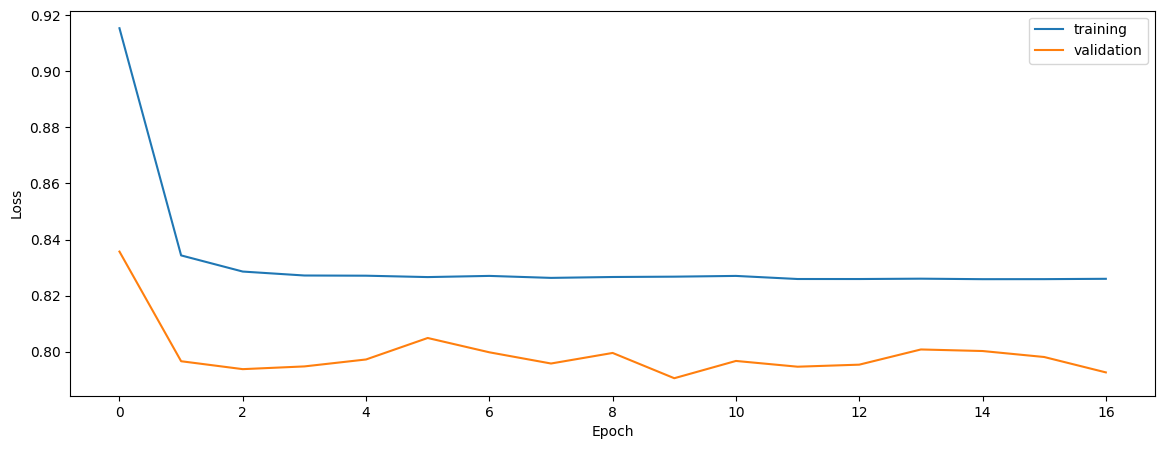

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


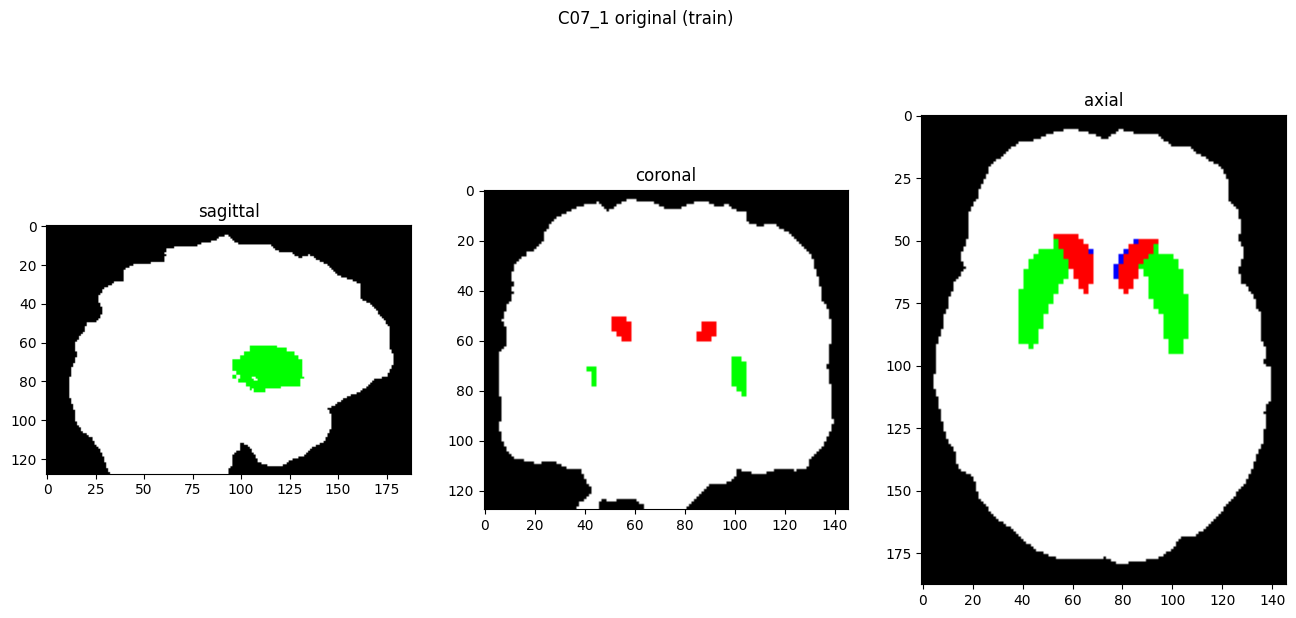

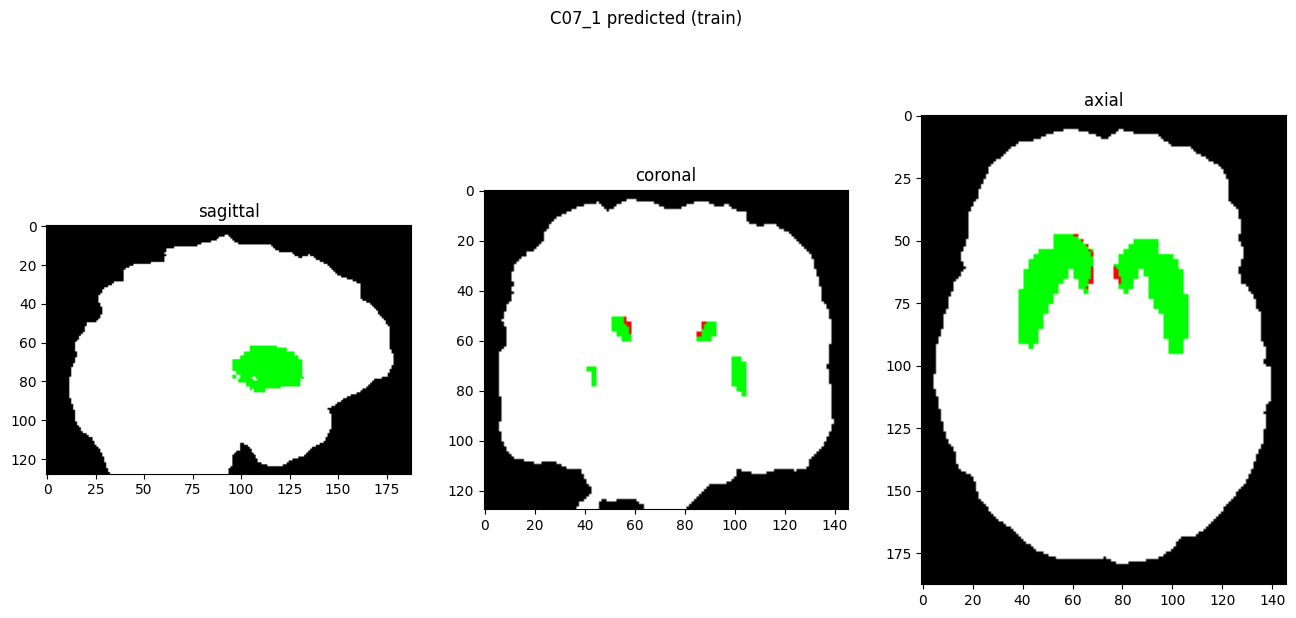

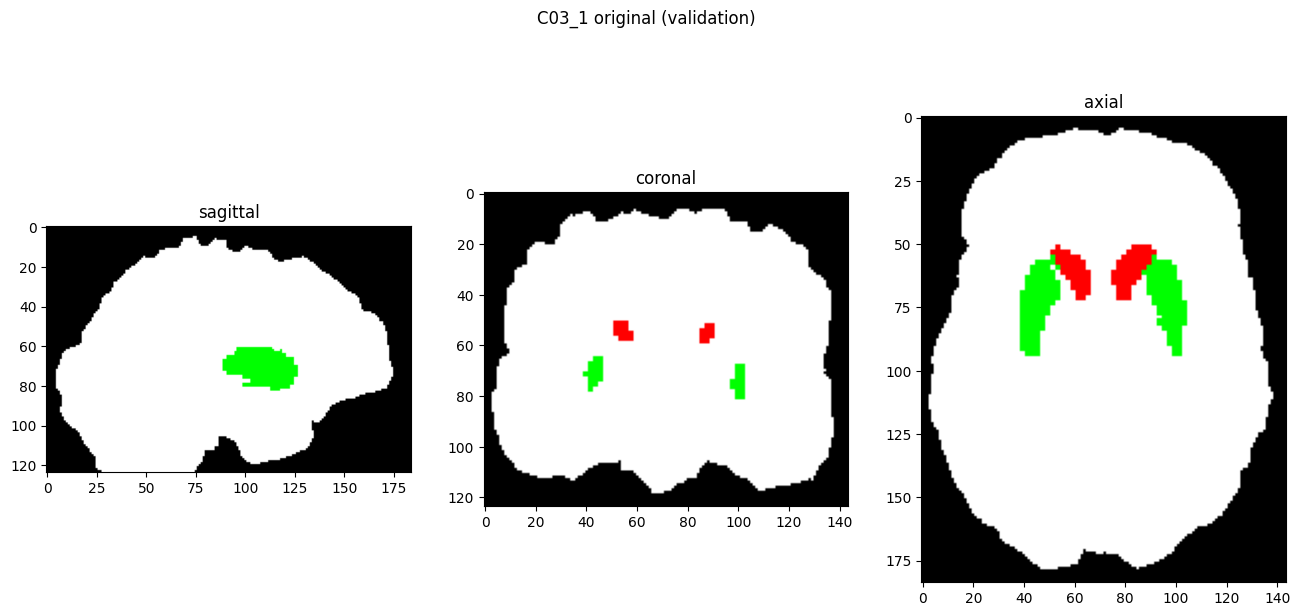

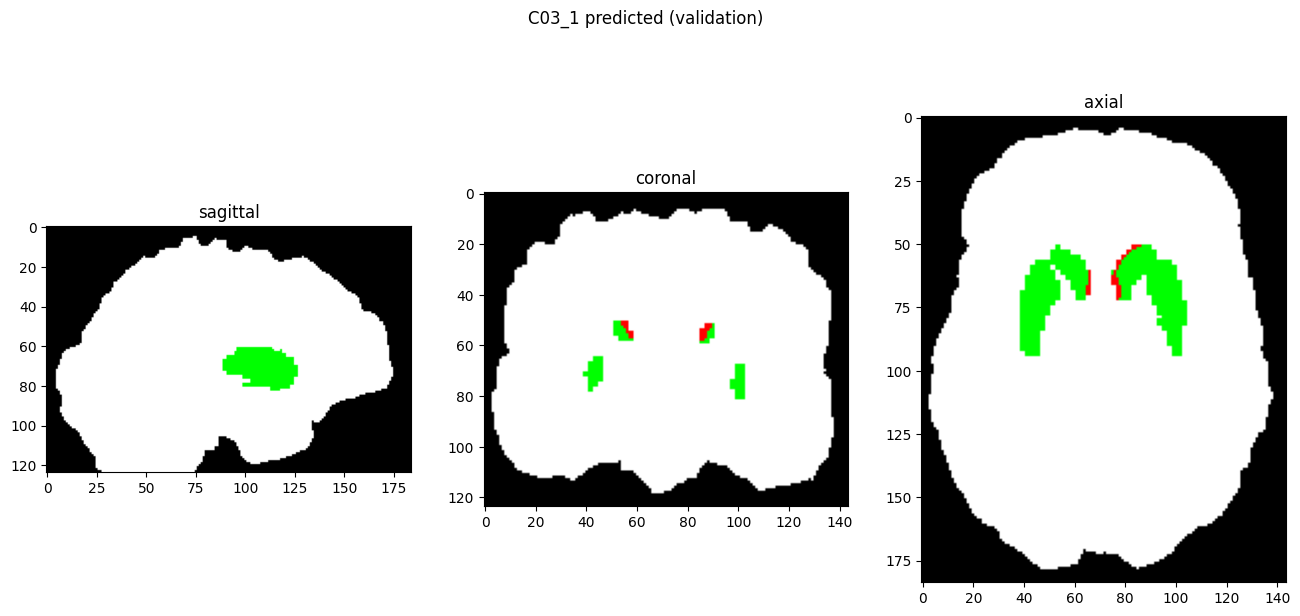

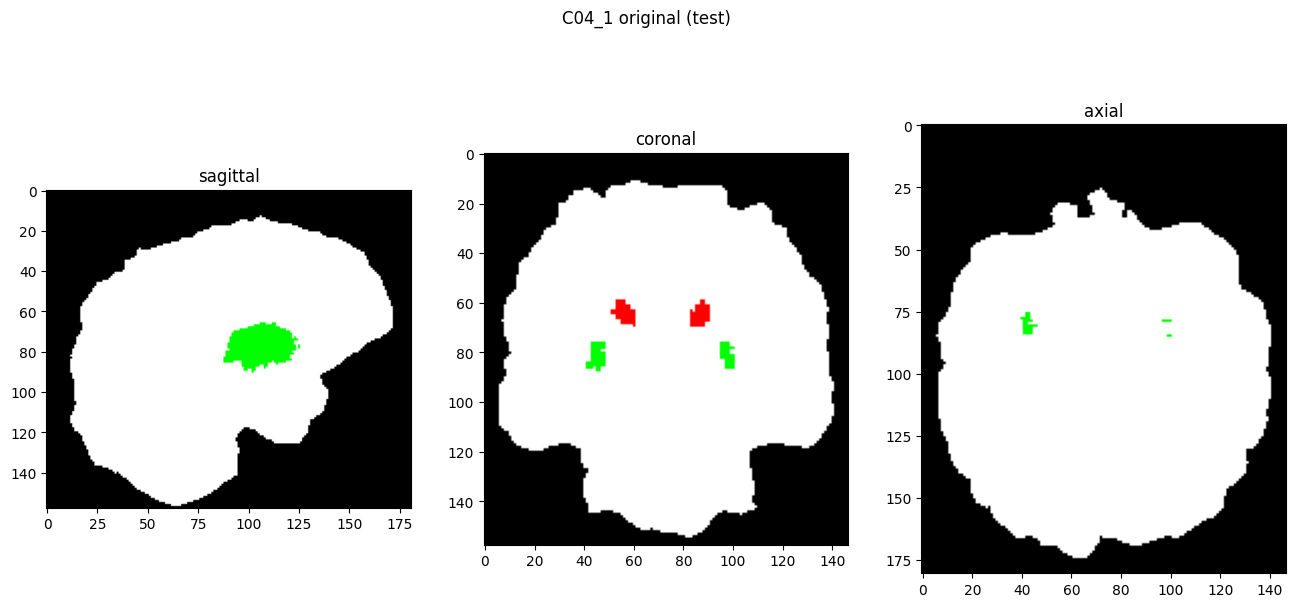

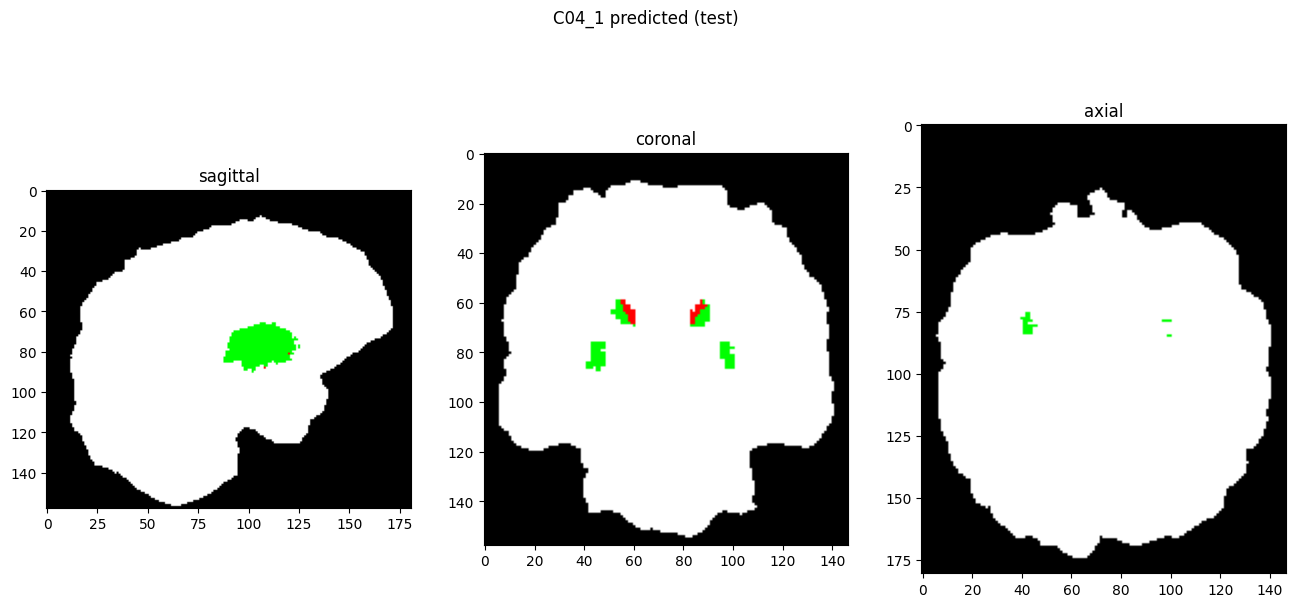

In [10]:
showResults(model, gen, threshold=0)